Loading model: NEURAL_NETWORK
Classification Report:
Category   Precision  Recall     F1-score  
----------------------------------------
Pizza      0.86      0.83      0.85
Shawarma   0.85      0.85      0.85
Sushi      0.82      0.85      0.83
----------------------------------------
Accuracy: 0.84 (329 samples)
Macro avg: 0.84      0.84      0.84
Weighted avg: 0.84      0.84      0.84

Bias-Variance Analysis:
Loss       Bias       Variance  
------------------------------
0.2269      0.2269      0.0731

LaTeX Table for Classification Report:

    \begin{table}[h]
        \centering
        \begin{tabular}{lccc}
            \hline
            Category & Precision & Recall & F1-score \\ 
            \hline
        Pizza    & 0.86 & 0.83 & 0.85 \\
        Shawarma    & 0.85 & 0.85 & 0.85 \\
        Sushi    & 0.82 & 0.85 & 0.83 \\
            \hline
            Accuracy      & \multicolumn{3}{c}{0.84 (329 samples)} \\
            Macro avg     & 0.84 & 0.84 & 0.84 \\
            Weight

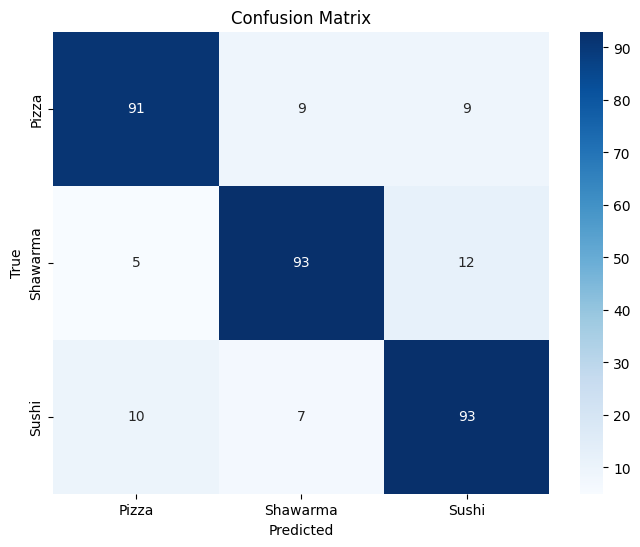

Loading model: LINEAR_REGRESSION
Classification Report:
Category   Precision  Recall     F1-score  
----------------------------------------
Pizza      0.86      0.89      0.87
Shawarma   0.89      0.87      0.88
Sushi      0.86      0.85      0.85
----------------------------------------
Accuracy: 0.87 (329 samples)
Macro avg: 0.87      0.87      0.87
Weighted avg: 0.87      0.87      0.87

Bias-Variance Analysis:
Loss       Bias       Variance  
------------------------------
0.2515      0.2515      0.0088

LaTeX Table for Classification Report:

    \begin{table}[h]
        \centering
        \begin{tabular}{lccc}
            \hline
            Category & Precision & Recall & F1-score \\ 
            \hline
        Pizza    & 0.86 & 0.89 & 0.87 \\
        Shawarma    & 0.89 & 0.87 & 0.88 \\
        Sushi    & 0.86 & 0.85 & 0.85 \\
            \hline
            Accuracy      & \multicolumn{3}{c}{0.87 (329 samples)} \\
            Macro avg     & 0.87 & 0.87 & 0.87 \\
            Wei

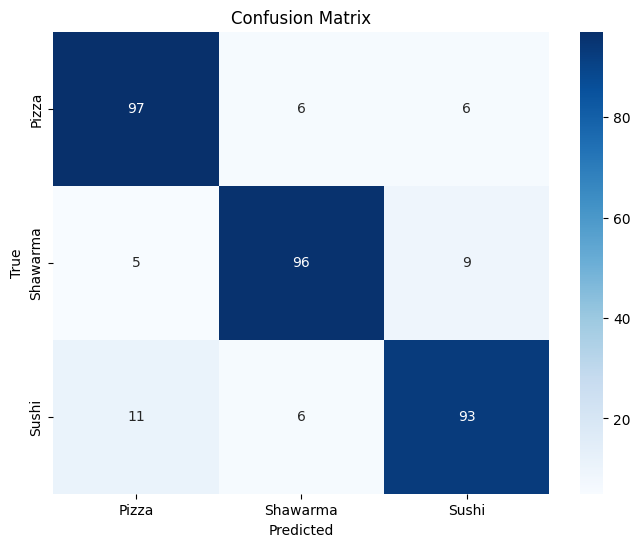

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from embedding_models import (
    DataProcessor,
    FoodEnum,
    ModelType,
    get_model,
)
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Function to convert labels to one-hot encoded vectors
def one_hot_encode(labels):
    """Convert text labels to one-hot encoded vectors"""
    result = np.zeros((len(labels), len(FoodEnum)))
    
    for i, label in enumerate(labels):
        result[i, FoodEnum.from_label(label)] = 1
    
    return result

# Load and prepare the data
data_path = "../cleaned_data_combined.csv"
df = pd.read_csv(data_path)

# Split features and labels
X = df.drop("Label", axis=1)
y = df["Label"]

# One-hot encode labels
y_encoded = one_hot_encode(y.to_numpy())
y_classes = np.array([FoodEnum.from_label(label) for label in y])

# Split data with a fixed random state for reproducibility
X_train, X_test, y_train_encoded, y_test_encoded, y_train_classes, y_test_classes = train_test_split(
    X, y_encoded, y_classes, test_size=0.2, random_state=42, stratify=y
)

for model_type in ModelType:
    # Load preprocessing parameters from the model file
    print(f"Loading model: {model_type.name}")
    params, model = get_model(model_type)

    # Preprocess data
    processor = DataProcessor(params)
    X_train_processed = processor.preprocess(X_train, y_train_encoded, train_mode=False)
    X_test_processed = processor.preprocess(X_test, y_test_encoded, train_mode=False)

    # Make predictions
    y_test_pred_proba = model.predict(X_test_processed)
    y_test_pred = np.argmax(y_test_pred_proba, axis=1)

    # Convert predictions to labels for the classification report
    labels = ["Pizza", "Shawarma", "Sushi"]
    target_names = labels

    # Calculate classification metrics
    report = classification_report(
        y_test_classes, 
        y_test_pred,
        target_names=target_names,
        output_dict=True
    )

    # Print classification report in a formatted way
    print("Classification Report:")
    print(f"{'Category':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10}")
    print("-" * 40)
    for label in target_names:
        precision = report[label]['precision']
        recall = report[label]['recall']
        f1 = report[label]['f1-score']
        print(f"{label:<10} {precision:.2f}{' '*5} {recall:.2f}{' '*5} {f1:.2f}")
    print("-" * 40)
    print(f"Accuracy: {report['accuracy']:.2f} ({len(y_test_classes)} samples)")
    print(f"Macro avg: {report['macro avg']['precision']:.2f}{' '*5} {report['macro avg']['recall']:.2f}{' '*5} {report['macro avg']['f1-score']:.2f}")
    print(f"Weighted avg: {report['weighted avg']['precision']:.2f}{' '*5} {report['weighted avg']['recall']:.2f}{' '*5} {report['weighted avg']['f1-score']:.2f}")

    # Calculate bias-variance decomposition
    def calculate_bias_variance(model, X_train, y_train_encoded, X_test, y_test_encoded):
        # Predict on training and test data
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate overall loss (MSE)
        test_loss = np.mean(np.sum((y_test_pred - y_test_encoded) ** 2, axis=1))
        
        # Calculate squared bias 
        # (difference between expected prediction and true labels)
        bias = np.mean(np.sum((y_test_pred - y_test_encoded) ** 2, axis=1))
        
        # Calculate variance (this is simplified and estimates model variance)
        # Using variation between train and test predictions as a proxy
        variance = np.abs(
            np.mean(np.sum((y_train_pred - y_train_encoded) ** 2, axis=1)) - 
            np.mean(np.sum((y_test_pred - y_test_encoded) ** 2, axis=1))
        )
        
        return test_loss, bias, variance

    # Calculate bias-variance metrics
    loss, bias, variance = calculate_bias_variance(
        model, X_train_processed, y_train_encoded, X_test_processed, y_test_encoded
    )

    # Print bias-variance metrics
    print("\nBias-Variance Analysis:")
    print(f"{'Loss':<10} {'Bias':<10} {'Variance':<10}")
    print("-" * 30)
    print(f"{loss:.4f}{' '*5} {bias:.4f}{' '*5} {variance:.4f}")

    # Generate LaTeX code for the tables
    print("\nLaTeX Table for Classification Report:")
    latex_table = """
    \\begin{table}[h]
        \\centering
        \\begin{tabular}{lccc}
            \\hline
            Category & Precision & Recall & F1-score \\\\ 
            \\hline"""

    for label in target_names:
        precision = report[label]['precision']
        recall = report[label]['recall']
        f1 = report[label]['f1-score']
        latex_table += f"\n        {label}    & {precision:.2f} & {recall:.2f} & {f1:.2f} \\\\"

    latex_table += f"""
            \\hline
            Accuracy      & \\multicolumn{{3}}{{c}}{{{report['accuracy']:.2f} ({len(y_test_classes)} samples)}} \\\\
            Macro avg     & {report['macro avg']['precision']:.2f} & {report['macro avg']['recall']:.2f} & {report['macro avg']['f1-score']:.2f} \\\\
            Weighted avg  & {report['weighted avg']['precision']:.2f} & {report['weighted avg']['recall']:.2f} & {report['weighted avg']['f1-score']:.2f} \\\\
            \\hline
        \\end{{tabular}}
        \\caption{{Classification Report}}
    \\end{{table}}
    """

    print(latex_table)

    print("\nLaTeX Table for Loss Report:")
    latex_loss_table = f"""
    \\begin{{table}}[h]
        \\centering
        \\begin{{tabular}}{{ccc}}
            \\hline
            Loss & Bias & Variance \\\\ 
            \\hline
            {loss:.4f} & {bias:.4f} & {variance:.4f} \\\\
            \\hline
        \\end{{tabular}}
    \\end{{table}}
    """

    print(latex_loss_table)

    # Visualize confusion matrix
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test_classes, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()